# New York City Parking Ticket Analysis

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

##### Preparation: Raw_data loading

In [307]:
filename = "Parking_Violations_Issued_-_Fiscal_Year_2017.csv"

In [308]:
print("loading data --- ", filename, "...")
raw_data = pd.read_csv(filename, low_memory = False)
print("done!")

loading data ---  Parking_Violations_Issued_-_Fiscal_Year_2017.csv ...
done!


In [340]:
start_date = '2016-07-01'
end_date = '2017-06-30'

In [341]:
raw_data.head(3)

,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,...,Vehicle Color,Unregistered Vehicle?,Vehicle Year,Meter Number,Feet From Curb,Violation Post Code,Violation Description,No Standing or Stopping Violation,Hydrant Violation,Double Parking Violation
0,5092469481,GZH7067,NY,PAS,07/10/2016,7,SUBN,TOYOT,V,0,...,GY,NaN,2001,NaN,0,NaN,FAILURE TO STOP AT RED LIGHT,NaN,NaN,NaN
1,5092451658,GZH7067,NY,PAS,07/08/2016,7,SUBN,TOYOT,V,0,...,GY,NaN,2001,NaN,0,NaN,FAILURE TO STOP AT RED LIGHT,NaN,NaN,NaN
2,4006265037,FZX9232,NY,PAS,08/23/2016,5,SUBN,FORD,V,0,...,BK,NaN,2004,NaN,0,NaN,BUS LANE VIOLATION,NaN,NaN,NaN


#### 1. Distribution of parking tickets issued over the fiscal year.

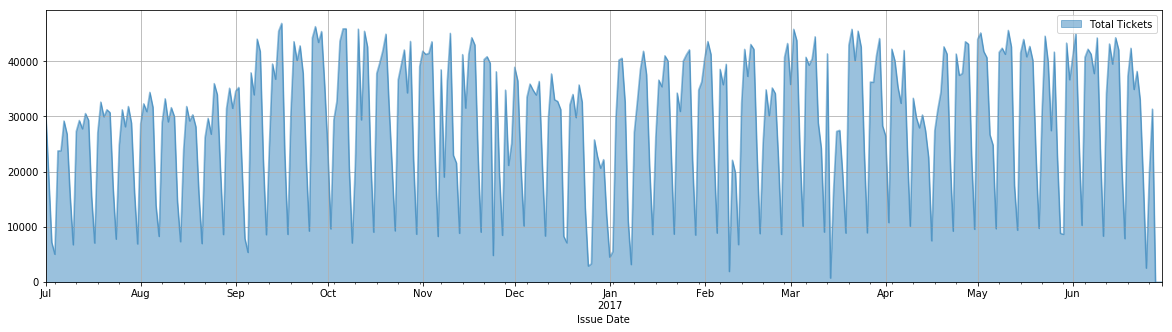

In [342]:
# Select the Columns with 'Issue Date' and 'Summons Number'
Date_SNum = raw_data[['Issue Date','Summons Number']]

# group the data by dates and count the total number of issued tickets on that date
Date_SNum = Date_SNum.groupby('Issue Date', as_index = False).count()

#Grouped data preview
Date_SNum['Issue Date'] = pd.to_datetime(Date_SNum['Issue Date'])

Date_SNum = Date_SNum.set_index('Issue Date')

#Select the tickets issued inside the fisical year range
Date_SNum = Date_SNum.loc[start_date : end_date]

#sort from start_date to end_date
Date_SNum = Date_SNum.sort_index()

#rename the Summons Number to Total Tickets, rename the dataframe too
Date_Total = Date_SNum.rename(columns = {"Summons Number" : "Total Tickets"})

fig1 = Date_Total.plot(kind = 'area', figsize = (20,5), alpha = 0.45, grid = True)

#### 2. Distribution of the traffic Tickets on the Day of Week

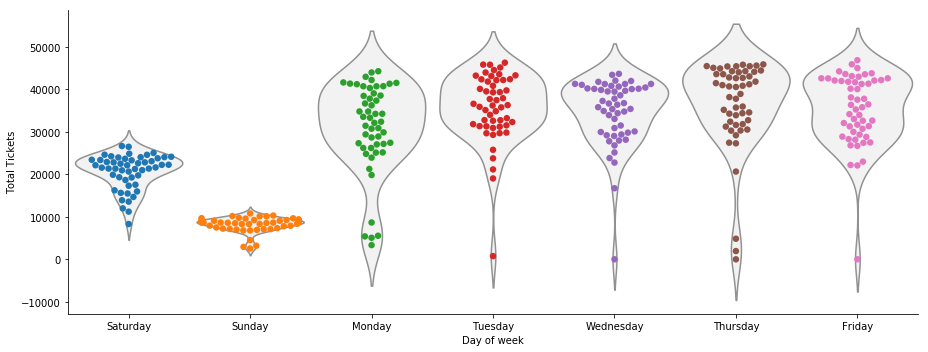

In [343]:
Date_Total["Day of week"] = Date_Total.index.day_name()

#violin plot for the number of tickets gave out on each weekday
fig2 = sns.catplot(x = "Day of week", y = "Total Tickets", data = Date_Total, kind = "violin", height = 5, width = 0.9, aspect = 13/5, order = ["Saturday", "Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday"], scale = "count", inner = None, color = "0.95")
fig2 = sns.swarmplot(x = "Day of week", y = "Total Tickets", data = Date_Total, order = ["Saturday", "Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday"], size = 6.5)

#### 3. Distribution of the traffic Tickets on the different month

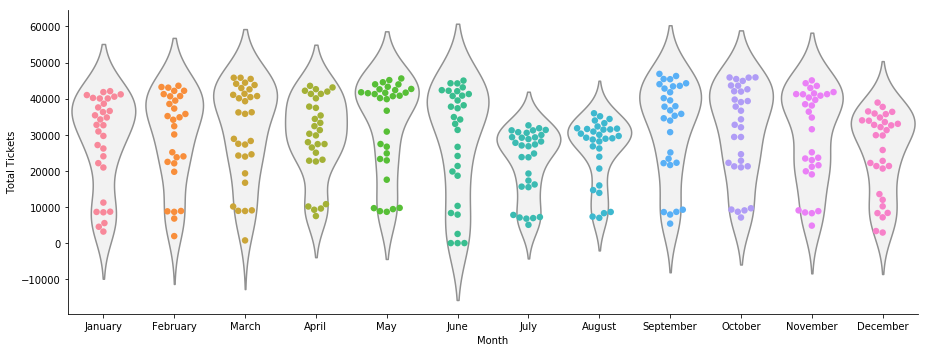

In [344]:
Date_Total["Month"] = Date_Total.index.month_name()

#violin plot for the number of tickets gave out on each weekday
fig3 = sns.catplot(x = "Month", y = "Total Tickets", data = Date_Total, kind = "violin", height = 5, width = 0.9, aspect = 13/5, order = ["January", "February", "March", "April", "May", "June", "July","August","September","October","November","December"], scale = "count", inner = None, color = "0.95")
fig3 = sns.swarmplot(x = "Month", y = "Total Tickets", data = Date_Total, order = ["January", "February", "March", "April", "May", "June", "July","August","September","October","November","December"], size = 6.5)

#### 4. Tickets given on Plate Types

In [365]:
Date_PT_TotalTX = raw_data[['Issue Date','Plate Type','Summons Number']]
# Fill any N/A with number string "N/A"
Date_PT_TotalTX = Date_PT_TotalTX.fillna("not_valid") 

In [366]:
Date_PT_TotalTX = Date_PT_TotalTX.groupby(['Issue Date','Plate Type'], as_index = False).count()

In [367]:
Date_PT_TotalTX['Issue Date'] = pd.to_datetime(Date_PT_TotalTX['Issue Date'])

In [368]:
Date_PT_TotalTX = Date_PT_TotalTX.set_index('Issue Date')
#Select the tickets issued inside the fisical year range
Date_PT_TotalTX = Date_PT_TotalTX.loc[start_date:end_date]
#drop the rows with plate type 999
Date_PT_TotalTX = Date_PT_TotalTX.loc[Date_PT_TotalTX['Plate Type'] != '999']

In [369]:
Date_PT_TotalTX

,Plate Type,Summons Number
Issue Date,,
2017-01-01,APP,4
2017-01-01,CMB,2
2017-01-01,COM,91
2017-01-01,IRP,7
2017-01-01,MED,5
2017-01-01,MOT,2
2017-01-01,OML,3
2017-01-01,OMR,6
2017-01-01,OMS,38
